In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.modeling.models import BlackBody
from scipy.optimize import minimize

from utils.fut import apod_recnuml
from utils.frd import elex_transfcnl
from utils.fut import get_recnum
from utils.frd import apodl
from utils.config import gen_nyquistl

We are following the following equation to get to a BB spectrum:

$$
D(\nu) = e^{i\nu\psi} H(\nu)^{-1} \left(\frac{1}{Z(\omega)B(\omega)} Y(\nu) - C(\nu)\right).
$$

In [2]:
f_nyquist = 145.212 / u.cm # from explanatory supplement
nu = np.arange(210)*(f_nyquist/320) + 2 / u.cm

f = nu.to(u.GHz, equivalencies=u.spectral())

x = np.linspace(1e-15, 1.22, 512) * u.cm

Get interferograms

In [3]:
# gmt = b'1990-01-19 08:14:04' # xcal in, both at around 2.75K
gmt = b'1989-12-20 23:46:11' # xcal in, ical 15K, xcal 8K

# get ifgs from cleaned data
# data = h5py.File("./../../data/df_v11.h5", "r")
data = h5py.File("/mn/stornext/u3/aimartin/d5/firas-reanalysis/Commander/commander3/todscripts/firas/data/df_v12.h5", "r")

# get id of the given gmt
idx = list(data["df_data/gmt"]).index(gmt)

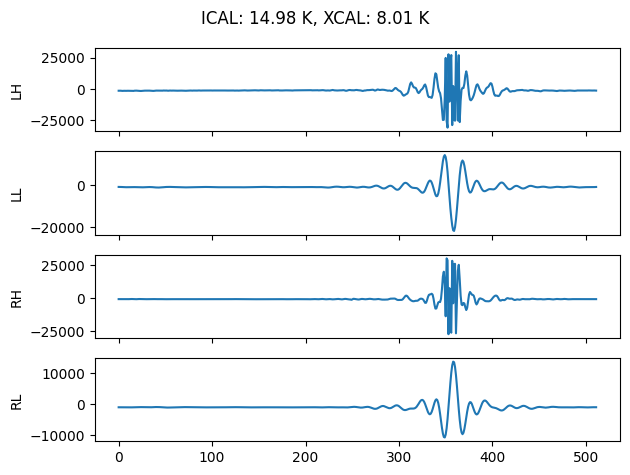

In [4]:
fig, ax = plt.subplots(sharex=True, nrows=4)
fig.subplots_adjust(hspace=0)

ax[0].plot(data["df_data/ifg_lh"][idx])
ax[1].plot(data["df_data/ifg_ll"][idx])
ax[2].plot(data["df_data/ifg_rh"][idx])
ax[3].plot(data["df_data/ifg_rl"][idx])

ax[0].set_ylabel("LH")
ax[1].set_ylabel("LL")
ax[2].set_ylabel("RH")
ax[3].set_ylabel("RL")

fig.suptitle(
    f"ICAL: {data['df_data/ical'][idx]:.2f} K, XCAL: {data['df_data/xcal'][idx]:.2f} K"
)

plt.tight_layout()
plt.show()

In [5]:
mtm_length = data["df_data/mtm_length"][idx]
mtm_speed = data["df_data/mtm_speed"][idx]

In [6]:
fake_it = 0

In [7]:
upmode = 4

In [8]:
adds_per_group = data["df_data/adds_per_group"][idx]
print(adds_per_group)

3.0


In [9]:
ifg_lh = data["df_data/ifg_lh"][idx]
ifg_ll = data["df_data/ifg_ll"][idx]
ifg_rh = data["df_data/ifg_rh"][idx]
ifg_rl = data["df_data/ifg_rl"][idx]

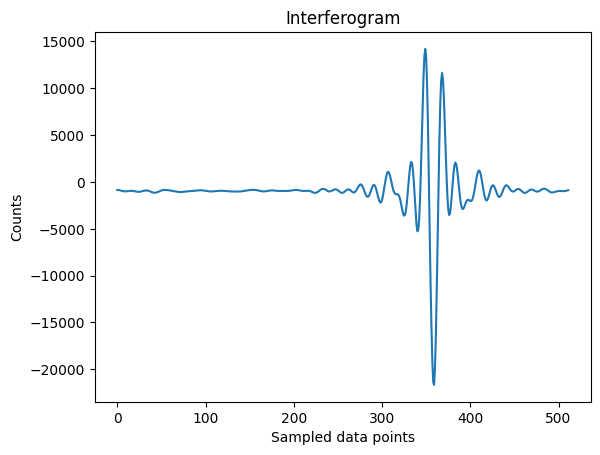

In [10]:
plt.plot(ifg_ll)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Interferogram")
plt.show()

Subtract the dither

In [11]:
ifg_ll = ifg_ll - np.median(ifg_ll)

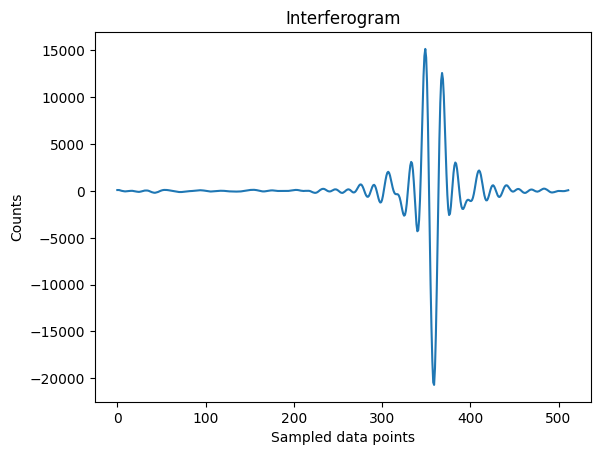

In [12]:
plt.plot(ifg_ll)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Interferogram")
plt.show()

## Find glitches

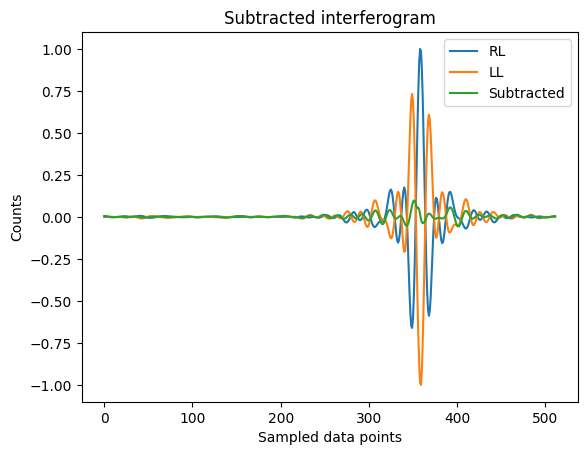

In [13]:
ifg_rl = ifg_rl - np.median(ifg_rl)
ifg_rl_norm = ifg_rl / np.max(np.abs(ifg_rl))

ifg_ll = ifg_ll - np.median(ifg_ll)
ifg_ll_norm = ifg_ll / np.max(np.abs(ifg_ll))

sub = ifg_rl_norm + ifg_ll_norm

plt.plot(ifg_rl_norm, label="RL")
plt.plot(ifg_ll_norm, label="LL")
plt.plot(sub, label="Subtracted")
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Subtracted interferogram")
plt.legend()
plt.show()

In [14]:
# determine level of white noise
noise = np.std(sub)

# find glitches in the data
glitches = np.where(np.abs(sub) > 5*noise)

tmp = glitches[0][0]
tmp_arr = np.array([tmp])
identified_glitches = np.array([])

j = 0

for i in glitches[0]:
    if i == tmp + 1:
        tmp_arr = np.append(tmp_arr, i)
    elif i - tmp > 1:
        max_pos = np.argmax(np.abs(sub[tmp_arr]))
        identified_glitches = np.append(identified_glitches, tmp_arr[max_pos])
        tmp_arr = np.array([i])
        tmp = i
    j += 1

# handle the last sequence of glitches
if len(tmp_arr) > 0:
    max_pos = np.argmax(np.abs(sub[tmp_arr]))
    identified_glitches = np.append(identified_glitches, tmp_arr[max_pos])

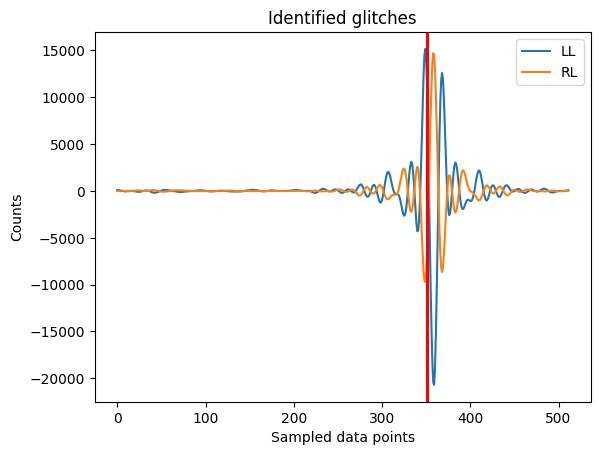

In [15]:
plt.plot(ifg_ll, label="LL")
plt.plot(ifg_rl, label="RL")
for glitch in identified_glitches:
    plt.axvline(x=glitch, color="red")
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Identified glitches")
plt.legend()
plt.show()

Need to figure out a way to find which channel the glitches belong to, for now I will do it manually and just take the first glitch, which corresponds to the LL channel.

In [16]:
glitch_center = identified_glitches.astype(int)[0]
tmp = ifg_ll[glitch_center]

if ifg_ll[glitch_center] > 0:
    sign = 1
else:
    sign = -1

if sign == 1: # positive peaks
    for i in range(len(ifg_ll) - glitch_center): # finding end of glitch region
        if ifg_ll[glitch_center + i] > tmp or ifg_ll[glitch_center + i] < 0:
            glitch_end = glitch_center + i
            break
        else:
            tmp = ifg_ll[glitch_center + i]
    
    tmp = ifg_ll[glitch_center]
            
    for i in range(len(ifg_ll) - glitch_center): # finding beginning of glitch region
        if ifg_ll[glitch_center - i] > tmp or ifg_ll[glitch_center - i] < 0:
            glitch_start = glitch_center - i
            break
        else:
            tmp = ifg_ll[glitch_center - i]
elif sign == -1: # negative peaks
    for i in range(len(ifg_ll) - glitch_center): # finding end of glitch region
        if ifg_ll[glitch_center + i] < tmp or ifg_ll[glitch_center + i] > 0:
            glitch_end = glitch_center + i
            break
        else:
            tmp = ifg_ll[glitch_center + i]

    tmp = ifg_ll[glitch_center]
    
    for i in range(len(ifg_ll) - glitch_center): # finding beginning of glitch region
        if ifg_ll[glitch_center - i] < tmp or ifg_ll[glitch_center - i] > 0:
            glitch_start = glitch_center - i
            break
        else:
            tmp = ifg_ll[glitch_center - i]

#### Electronics transfer function

In [17]:
channel = 3 # (LL)

etfl_all = elex_transfcnl(samprate=681.43, nfreq=len(ifg_ll)//2+1)
erecno = int(get_recnum(fake_it, mtm_speed, channel, upmode, adds_per_group))
etf = etfl_all[erecno, :]

etfl_all = elex_transfcnl(samprate=681.43, nfreq=len(ifg_ll))
etf_512 = etfl_all[erecno, :]

#### FITS data

In [18]:
fits_data = fits.open('./../../reference/FIRAS_CALIBRATION_MODEL_LLSS.FITS')

#### Glitch profile

In [19]:
v = 0.8 * u.cm / u.s # slow speed
tau = fits_data[1].data['TIME_CON'][0] * u.s

def gp(x, Omega):
    # re-map nu to be 512 points long and then crop to glitch region
    nu_512 = (np.linspace(0, 1, 512) * np.max(nu).value + 2) 
    nu_glitch = nu_512[glitch_start:glitch_end]
    # nu_glitch = np.arange(glitch_start, glitch_end)

    v_array = np.full(nu_glitch.shape, v.value)
    tau_array = np.full(nu_glitch.shape, tau.value)

    result = -np.array([Omega**(-1) * np.trapezoid(np.exp(-2*np.pi*1j*nu_glitch*xi) * etf_512[glitch_start:glitch_end]/(1 + 1j * v_array * nu_glitch * tau_array), nu_glitch) for xi in x])
    
    # Ensure the result is a numpy array of floats
    result = np.asarray(result, dtype=float)  
    return result

#### Fit glitch profile to data

##### Guess

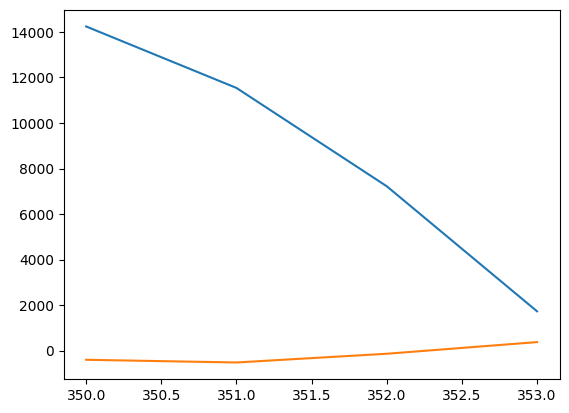

In [20]:
guess = 0.005

plt.plot(np.arange(glitch_start,glitch_end), ifg_ll[glitch_start:glitch_end])
plt.plot(np.arange(glitch_start,glitch_end), gp(x[glitch_start:glitch_end].value, guess))
plt.show()

In [21]:
def residual_glitch(Omega):
    return np.sum((ifg_ll[glitch_start:glitch_end] - gp(np.arange(glitch_start, glitch_end), Omega))**2)

In [22]:
# fit = curve_fit(gp, x[glitch_start:glitch_end], ifg_ll[glitch_start:glitch_end], p0=[guess])[0]
fit = minimize(residual_glitch, guess)

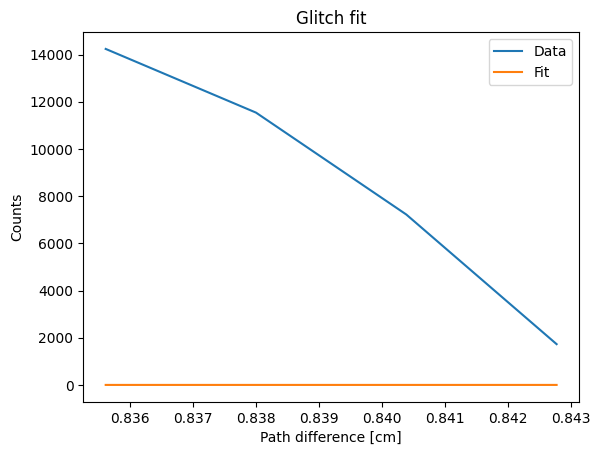

In [23]:
plt.plot(x[glitch_start:glitch_end], ifg_ll[glitch_start:glitch_end], label="Data")
plt.plot(x[glitch_start:glitch_end], gp(x[glitch_start:glitch_end].value, fit.x), label="Fit")
plt.xlabel("Path difference [cm]")
plt.ylabel("Counts")
plt.title("Glitch fit")
plt.legend()
plt.show()

In [24]:
# deglitched_ifg = ifg_ll[glitch_start:glitch_end] - gp(x[glitch_start:glitch_end].value, fit)

# plt.plot(deglitched_ifg)
# plt.xlabel("Sampled data points")
# plt.ylabel("Counts")
# plt.title("Deglitched interferogram")
# plt.show()

In [25]:
# for now let's ignore the glitches
deglitched_ifg = ifg_ll

Apodize

In [26]:
sm = 2 * mtm_length + mtm_speed

arecno = int(apod_recnuml(channel, sm, fake_it, upmode, adds_per_group, 0))

In [27]:
apodl_all = apodl()
apod = apodl_all[arecno, :]

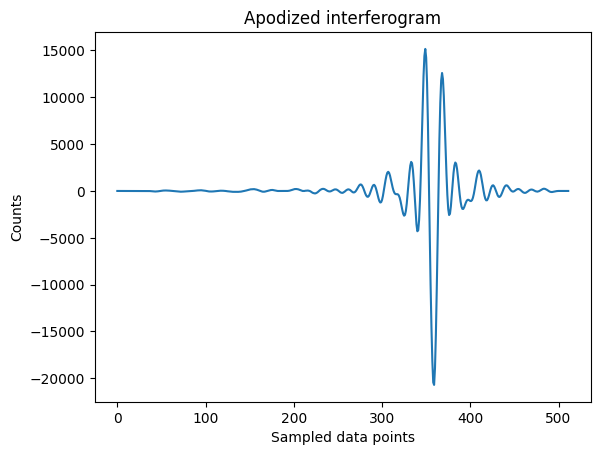

In [28]:
ai = apod * deglitched_ifg

plt.plot(ai)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Apodized interferogram")
plt.show()

Padding

In [29]:
# there is no padding in the original pipeline

# padding = np.zeros(640 - 512)
# padded = np.concatenate((ai, padding))

# plt.plot(padded)
# plt.xlabel("Sampled data points")
# plt.ylabel("Counts")
# plt.title("Padded interferogram")
# plt.show()

Roll

In [30]:
peak_pos = 360
# rolled_ifg = np.roll(padded, -peak_pos)
rolled_ifg = np.roll(ai, -peak_pos)

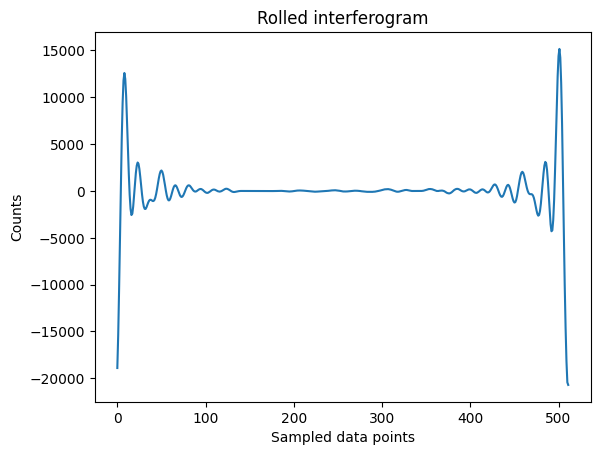

In [31]:
plt.plot(rolled_ifg)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Rolled interferogram")
plt.show()

Fourier transform

(257,)


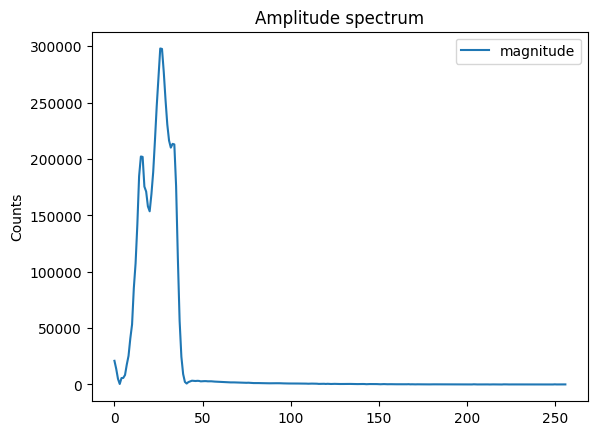

In [32]:
# y = np.fft.rfft(padded)
y = np.fft.rfft(rolled_ifg)
print(y.real.shape)

plt.plot(np.abs(y), label='magnitude') # plotting the amplitude spectrum
plt.ylabel("Counts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

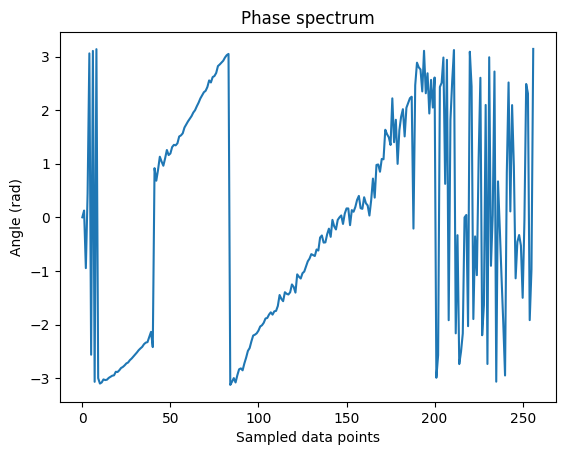

In [33]:
plt.plot(np.angle(y)) # plotting the phase spectrum
plt.xlabel("Sampled data points")
plt.ylabel("Angle (rad)")
plt.title("Phase spectrum")
plt.show()

Electronics transfer function to get the volts

In [34]:
chan = 3 # LL
scan_mode = 0 # SS
frec = 4 * (chan % 2) + scan_mode

fnyq_icm = gen_nyquistl('../../reference/fex_samprate.txt', '../../reference/fex_nyquist.txt', 'int')['icm'][frec]

fac_etendu = 1.5 # nathan's pipeline
fac_adc_scale = 204.75 # nathan's pipeline

spec_norm = fnyq_icm * fac_etendu * fac_adc_scale

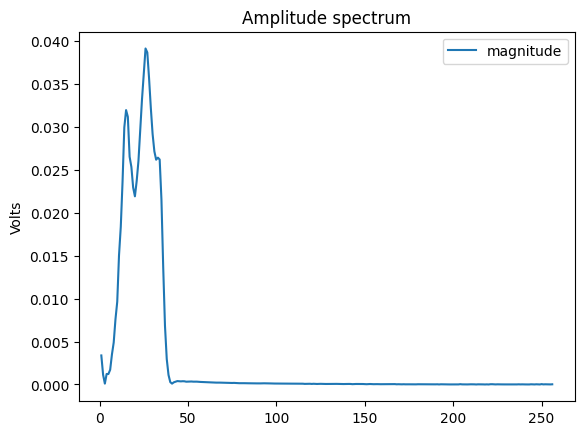

In [35]:
# yz = y / (etf * spec_norm) * u.V / u.cm**2 / u.sr / u.cm**(-1)
yz = y / (etf * spec_norm) * u.V 

plt.plot(np.abs(yz), label='magnitude') # plotting the amplitude spectrum
plt.ylabel("Volts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

Bolometer model

In [36]:
fits_data[1].header

XTENSION= 'BINTABLE'           / Extension type is Binary Table                 
BITPIX  =                    8 / Binary data                                    
NAXIS   =                    2 / Data are in a table                            
NAXIS1  =                15600 / Number of 8 bit bytes in each row              
NAXIS2  =                    1 / Number of rows                                 
PCOUNT  =                    0 / Number of bytes of data following table        
GCOUNT  =                    1 / Group count (always 1 for bintable extensions) 
TFIELDS =                   45 / Number of fields (columns) in the table        
COMMENT                                                                         
COMMENT                                                                         
COMMENT    FIRAS Calibration Model Solution                                     
COMMENT    Project Dataset Record Structure                                     
COMMENT                     

In [37]:
# S0 = fits_data[1].data['DC_RESPO'][0] * u.V / u.W
# print(S0)
# S0 = S0.to(u.V / u.erg * u.s)
# gain_norm = 7.479336 * u.MJy * u.V / u.W / u.sr

In [38]:
rscale = 1.0e-7

bol_cmd_bias = data["df_data/bol_cmd_bias_ll"][idx]
cmd_bias = np.double(bol_cmd_bias) / 25.5

bol_volt = data["df_data/bol_volt_ll"][idx]
Jo = fits_data[1].data['BOLPARM8'][0]
Jg = fits_data[1].data['BOLPARM9'][0]
V = (bol_volt - Jo) / Jg

RL = 4.0e7
R = RL*V / (cmd_bias - V)

drift_amp = fits_data[1].data['DRIFT_AM'][0]
drift_tc = 1 / fits_data[1].data['DRIFT_TC'][0]
drift_of = fits_data[1].data['DRIFT_OF'][0]
times = data["df_data/time"][idx]
ticald = drift_amp * np.exp(-drift_tc*times) - drift_of

Tbol = fits_data[1].data['BOLOM_B2'][0]
G1 = fits_data[1].data['BOLPARM3'][0]
beta = fits_data[1].data['BOLPARM4'][0]
G = G1*Tbol**beta

rho = fits_data[1].data['BOLPARM5'][0]
X = V*rho

H = Tbol / X * np.tanh(X/Tbol)

T0 = fits_data[1].data['BOLPARM2'][0]
DT = 1.0/H - 1.0 - 0.5*np.sqrt(T0/Tbol)

Z = (G*Tbol*R + DT*V**2) / (G*Tbol*R/H - DT*V**2)

S0 = rscale * R * (Z-H) / (V * (Z*R/RL + 1.0) * (H + 1.0))

In [39]:
fnyq_hz = gen_nyquistl('../../reference/fex_samprate.txt', '../../reference/fex_nyquist.txt', 'int')['hz']

In [40]:
# according to fsl
fcc_spec_length = 321
spec_len = len(ifg_ll) // 2 + 1
dw = 2.0 * np.pi * fnyq_hz[frec] / spec_len

afreq = np.arange(fcc_spec_length) * dw * u.rad / u.s

In [41]:
# from header of fits file
domega = 2.2299744 * u.rad / u.s 
omega = np.arange(210) * domega + 11.149872 * u.rad / u.s

In [42]:
# bolometer = S0 / (1 + 1j * omega.value * tau.value)
B = 1.0 + 1j * np.outer(tau.value, afreq.value)

In [43]:
# yzb = B * yz / denom

# plt.plot(f, yzb.real[:210], label='real')
# plt.plot(f, yzb.imag[:210], label='imag') 
# plt.plot(f, np.abs(yzb)[:210], label='magnitude') # plotting the amplitude spectrum
# plt.xlabel("Frequency (GHz)")
# plt.ylabel("Watts")
# plt.title("Amplitude spectrum")
# plt.legend()
# plt.show()

Cut off high frequencies

Mapping of correct frequencies to the points in the IFG and the given functions (OTF, etc)?

In [44]:
# cutoff = yzb[:43]

In [45]:
# plt.plot(f[:43], cutoff.real, label='real')
# plt.plot(f[:43], cutoff.imag, label='imag')
# plt.plot(f[:43],np.abs(cutoff), label='magnitude') # plotting the amplitude spectrum
# plt.xlabel("Frequency (GHz)")
# plt.ylabel("Watts")
# plt.title("Amplitude spectrum")
# plt.legend()
# plt.show()

todo: missing vibration and corrections terms

Optical transfer function

In [46]:
fits_data[1].header

XTENSION= 'BINTABLE'           / Extension type is Binary Table                 
BITPIX  =                    8 / Binary data                                    
NAXIS   =                    2 / Data are in a table                            
NAXIS1  =                15600 / Number of 8 bit bytes in each row              
NAXIS2  =                    1 / Number of rows                                 
PCOUNT  =                    0 / Number of bytes of data following table        
GCOUNT  =                    1 / Group count (always 1 for bintable extensions) 
TFIELDS =                   45 / Number of fields (columns) in the table        
COMMENT                                                                         
COMMENT                                                                         
COMMENT    FIRAS Calibration Model Solution                                     
COMMENT    Project Dataset Record Structure                                     
COMMENT                     

43

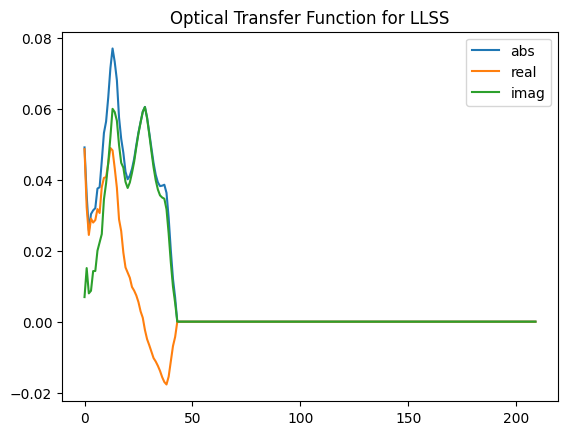

In [47]:
otf = fits_data[1].data["RTRANSFE"][0] + 1j * fits_data[1].data["ITRANSFE"][0]

plt.plot(np.abs(otf), label='abs') # plotting the amplitude spectrum
plt.plot(otf.real, label='real')
plt.plot(otf.imag, label='imag')
plt.title("Optical Transfer Function for LLSS")
plt.legend()
len(otf[np.abs(otf) > 0])

In [48]:
# points to consider
trlim = 1.0e-10
idxs = np.where(np.abs(otf) > trlim)[0]

In [49]:
denom = np.outer(S0, otf[idxs])

In [50]:
spec = np.zeros(len(ifg_lh) // 2 + 1, dtype=complex)
spec[idxs] = (B[:, idxs] * yz[idxs] / denom) #* u.erg / u.s / u.cm**2 / u.sr / u.cm**(-1)

Why do we need to force the unit? Shoudldn't the OTF come with units? -- Problem with getting $D(\nu)$ into the right units

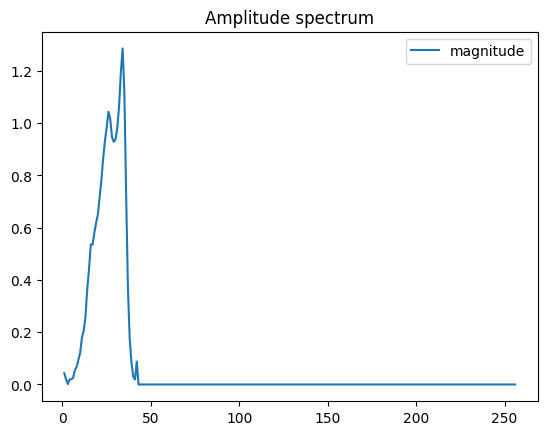

In [51]:
# yzbh = cutoff / otf[:43]
# # yzbh = yzbh.value * u.MJy / u.sr

plt.plot(np.abs(spec), label='magnitude') # plotting the amplitude spectrum
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

In [52]:
phase = 1e-5 #* u.cm

# d = np.exp(1j*nu[:43]*phase) * yzbh
d = np.exp(1j*idxs*phase) * spec[idxs]
d = d * u.erg / u.s / u.cm**2 / u.sr / u.cm**(-1)

fac_icm_ghz = 29.9792458
fac_erg_to_mjy = 1.0e8 / fac_icm_ghz

d = d * fac_erg_to_mjy
d = d.value * u.MJy / u.sr
d_save = d

todo: recheck this?

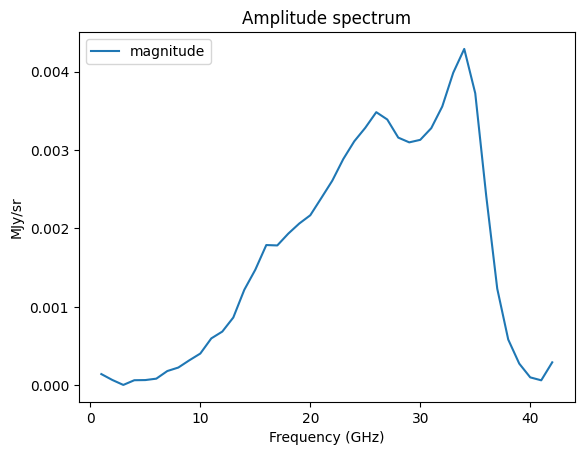

In [68]:
plt.plot(np.abs(d), label='magnitude') # plotting the amplitude spectrum
plt.title("Amplitude spectrum")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.legend()
plt.show()

In [69]:
(0.1 * (u.erg * 1e-6) / u.cm**2 / u.s / u.sr / u.cm).to(u.MJy / u.sr, equivalencies=u.spectral_density(1 * u.cm))

<Quantity 0.3335641 MJy / sr>

In [70]:
ical_emiss = fits_data[1].data["RICAL"][0] + 1j * fits_data[1].data["IICAL"][0]

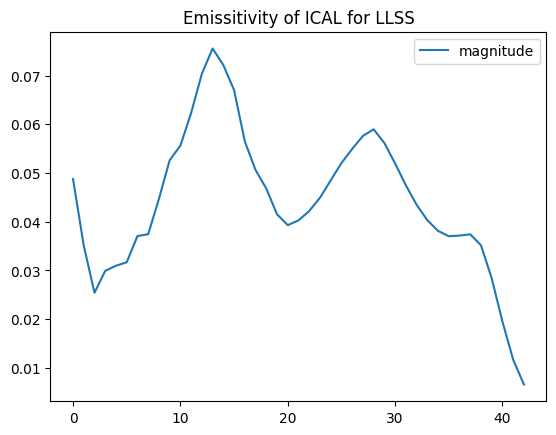

In [71]:
plt.plot(np.abs(ical_emiss)[:43], label='magnitude') # plotting the amplitude spectrum
plt.title("Emissitivity of ICAL for LLSS")
plt.legend()
plt.show()

In [72]:
t_ical = data["df_data/ical"][idx] * u.K

bb_ical = (BlackBody(temperature=t_ical)(f[:43]) * ical_emiss[:43]).to(u.MJy / u.sr)

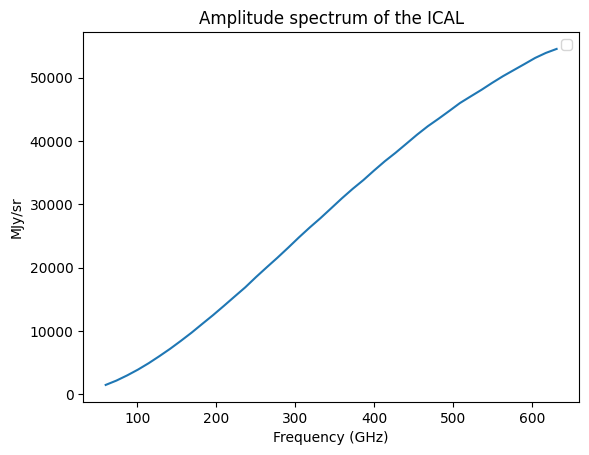

In [73]:
plt.plot(f[:43], np.abs(bb_ical / otf[:43])) # plotting the amplitude spectrum
plt.title("Amplitude spectrum of the ICAL")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.legend()
plt.show()

In [74]:
scale = 1e-9
d = d_save * scale

sky = d - bb_ical / otf[:43]

if data['df_data/xcal'][idx] < data['df_data/ical'][idx]:
    print("XCAL < ICAL")
    sky = (-1) * sky

XCAL < ICAL


In [75]:
def blackbody_model(frequency, temperature):
    bb = BlackBody(temperature * u.K)
    return bb(frequency).to("MJy sr-1").value

p0 = [8]
bounds = [(0, 26)]

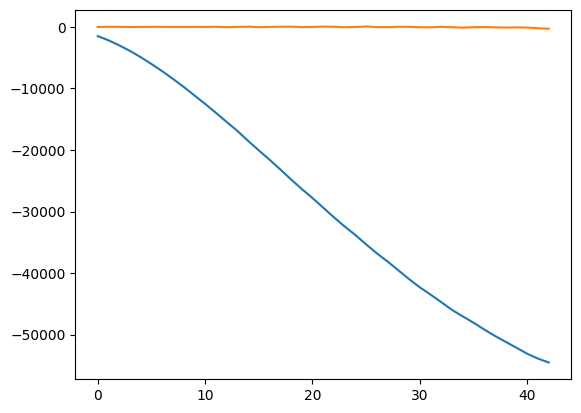

In [76]:
plt.plot((bb_ical / otf[:43]).real, label='real')
plt.plot((bb_ical / otf[:43]).imag, label='imag')
plt.show()

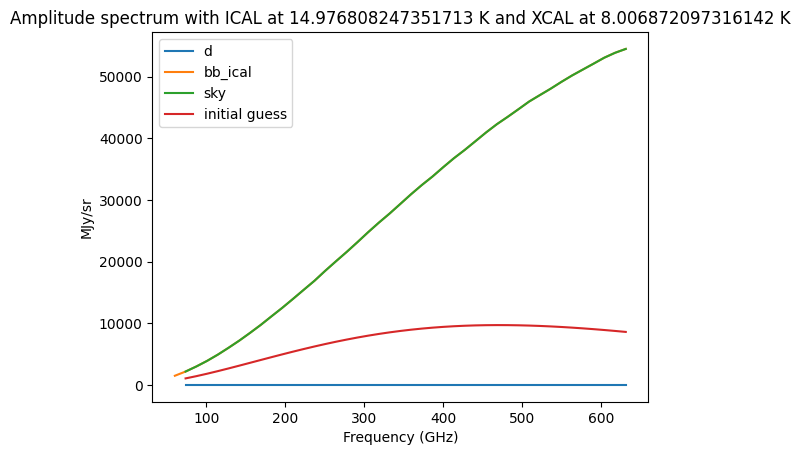

In [77]:
plt.plot(f[:43], np.abs(d), label="d")
plt.plot(f[:43], np.abs(bb_ical / otf[:43]), label="bb_ical")
plt.plot(f[:43], np.abs(sky), label="sky") # plotting the amplitude spectrum
plt.plot(f[1:43], blackbody_model(f[1:43], p0[0]), label="initial guess")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.title(f"Amplitude spectrum with ICAL at {data["df_data/ical"][idx]} K and XCAL at {data["df_data/xcal"][idx]} K")
plt.legend()
plt.show()

### Fitting

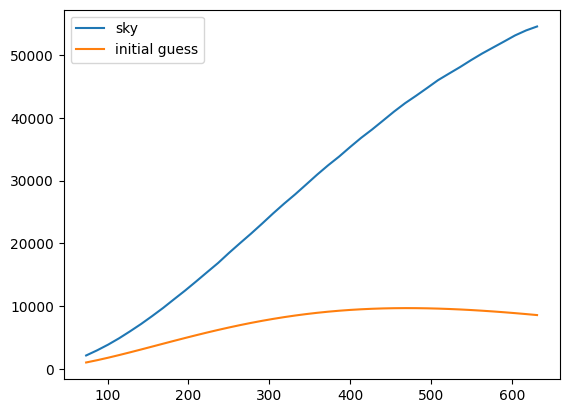

In [78]:
plt.plot(f[1:43], np.abs(sky[1:]), label="sky") # plotting the amplitude spectrum
plt.plot(f[1:43], blackbody_model(f[1:43], p0[0]), label="initial guess")
plt.legend()
plt.show()

In [79]:
def residuals(temperature, frequency_data, sky_data): # doing least squares for now
    return np.sum((sky_data - blackbody_model(frequency_data, temperature[0]))**2)

In [80]:
result = minimize(residuals, p0, args=(f[1:43], np.abs(sky[1:43]).value), bounds=bounds)
fitted_temperature = result.x[0]

print(f"Fitted temperature: {fitted_temperature} K, real temperature: {data['df_data/xcal'][idx]} K, ICAL temperature: {data['df_data/ical'][idx]} K")

Fitted temperature: 14.760263067935085 K, real temperature: 8.006872097316142 K, ICAL temperature: 14.976808247351713 K


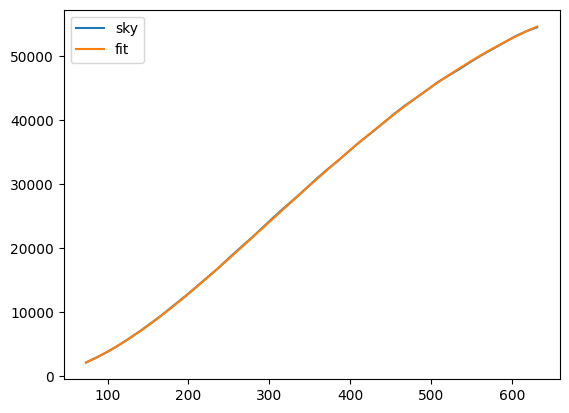

In [81]:
plt.plot(f[1:43], np.abs(sky)[1:], label="sky")
plt.plot(f[1:43], blackbody_model(f[1:43], fitted_temperature), label="fit")
plt.legend()
plt.show()